# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [162]:
import pandas as pd
import numpy as np
import math
import json
from datetime import date

#for visualization
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [163]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [164]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [165]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


# Data cleansing

In [166]:
# look for missing values in Dataframe 
def missing_values_table(df):
    '''
    Intput:
    - dataframe - (pandas dataframe)
    
    Output:
    - table summarize missing values
    
    '''
    zero_val = (df == 0.00).astype(int).sum(axis=0)
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
    mz_table = mz_table.rename(
    columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
    mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
    mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
    mz_table['Data Type'] = df.dtypes
    mz_table = mz_table[
        mz_table.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("This dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
        "There are " + str(mz_table.shape[0]) +
          " columns that have missing values.")

    return mz_table



In [167]:
missing_values_table(portfolio)

This dataframe has 6 columns and 10 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


In [168]:
missing_values_table(profile)

This dataframe has 5 columns and 17000 Rows.
There are 2 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
gender,0,2175,12.8,2175,12.8,object
income,0,2175,12.8,2175,12.8,float64


In [169]:
missing_values_table(transcript)

This dataframe has 4 columns and 306534 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


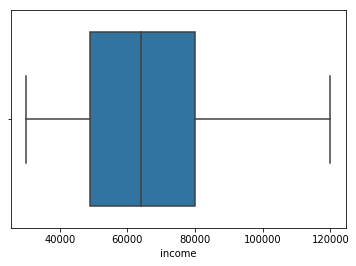

In [170]:
# check with the pattern using boxplot
sns.boxplot(profile.income)

In [171]:
'''
portfolio
'''
#split channels into separate channel columns
channels = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)
portfolio = pd.concat([portfolio, channels], axis=1) 
#rename column id to offer_id
portfolio. rename(columns = {'id':'offer_id'}, inplace = True)
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [172]:
portfolio['email'] = portfolio['email'].astype(int)
portfolio['mobile'] = portfolio['mobile'].astype(int)
portfolio['social'] = portfolio['social'].astype(int)
portfolio['web'] = portfolio['web'].astype(int)


In [173]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_id      10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
email         10 non-null int64
mobile        10 non-null int64
social        10 non-null int64
web           10 non-null int64
dtypes: int64(7), object(3)
memory usage: 880.0+ bytes


In [174]:
'''
profile
'''
#profile - check duplicate
profile.duplicated().sum()

0

In [175]:
#convert became_member_on from string to date
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
#rename column id to customer_id
profile.rename(columns = {'id':'customer_id'}, inplace = True)
profile.head()


,age,became_member_on,gender,customer_id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [176]:
'''
transcript
'''
#rename person to customer_id
transcript.rename(columns = {'person':'customer_id'}, inplace = True)
transcript.head()

,event,customer_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [177]:
transcript['offer_id'] = [[*i.values()][0]if [*i.keys()][0] in ['offer id','offer_id'] else None for i in transcript.value]
transcript['amount'] = [np.round([*i.values()][0], decimals=2)if [*i.keys()][0] == 'amount' else None for i in transcript.value]
transcript.head()

,event,customer_id,time,value,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [178]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [179]:
transcript.event.isnull().sum()

0

In [180]:
#concat the 3 datasets 
t_profile = pd.merge(transcript, profile, on='customer_id', how='outer')
all_trx = pd.merge(t_profile, portfolio, on='offer_id', how='outer')
all_trx.head()

,event,customer_id,time,value,offer_id,amount,age,became_member_on,gender,income,channels,difficulty,duration,offer_type,reward,email,mobile,social,web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,2017-05-09,F,100000.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,2017-05-09,F,100000.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,2017-05-09,F,100000.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
3,offer received,e2127556f4f64592b11af22de27a7932,408,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,68,2018-04-26,M,70000.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
4,offer viewed,e2127556f4f64592b11af22de27a7932,420,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,68,2018-04-26,M,70000.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0


In [181]:
offer_ids = all_trx['offer_id'].unique()
offer_ids

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9', None,
       '5a8bc65990b245e5a138643cd4eb9837',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '3f207df678b143eea3cee63160fa8bed',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '2298d6c36e964ae4a3e7e9706d1fb8c2'], dtype=object)

In [182]:
offer_dict = pd.Series(offer_ids).to_dict()
offer_dict = dict([(value, key) for key, value in offer_dict.items()]) 
offer_dict

{'9b98b8c7a33c4b65b9aebfe6a799e6d9': 0,
 None: 1,
 '5a8bc65990b245e5a138643cd4eb9837': 2,
 'ae264e3637204a6fb9bb56bc8210ddfd': 3,
 'f19421c1d4aa40978ebb69ca19b0e20d': 4,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 5,
 '3f207df678b143eea3cee63160fa8bed': 6,
 '2906b810c7d4411798c6938adc9daaa5': 7,
 'fafdcd668e3743c1bb461111dcafc2a4': 8,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 9,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 10}

In [183]:
portfolio['offer_name'] = portfolio['offer_type']+'-'+portfolio['offer_id'].map(offer_dict).astype(str)
portfolio.sort_values(by=['offer_type'])

,channels,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web,offer_name
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,bogo-3
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,bogo-9
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,bogo-0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,bogo-4
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,discount-5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,discount-10
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,discount-8
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1,discount-7
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,informational-6
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0,informational-2


In [184]:
#assign offer name for easy reference 

all_trx['offer_name'] = all_trx['offer_type']+'-'+all_trx['offer_id'].map(offer_dict).astype(str)
all_trx.offer_name.unique()

array(['bogo-0', nan, 'informational-2', 'bogo-3', 'bogo-4', 'discount-5',
       'informational-6', 'discount-7', 'discount-8', 'bogo-9',
       'discount-10'], dtype=object)

In [185]:
all_trx.to_csv('data/data.csv', index=False)

# Data exploration and visulization

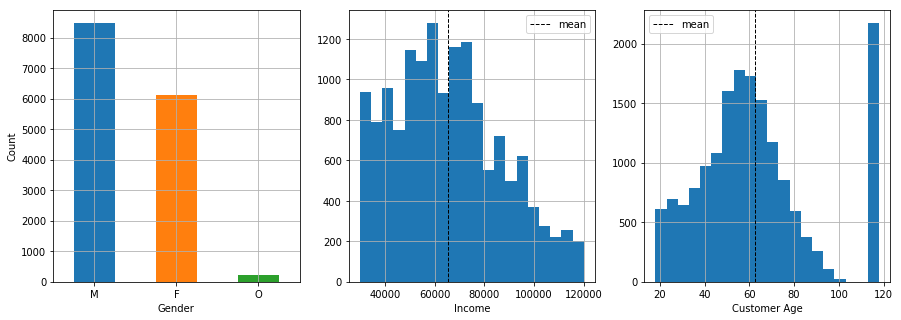

In [186]:
#create charts to show the customer demographics
plt.figure(figsize=(15,5))

plt.subplot(131)
profile.gender.value_counts().reindex(['M','F','O']).plot(kind='bar', rot=0)
plt.ylabel('Count')
plt.xlabel('Gender')
plt.grid()

plt.subplot(132)
plt.xlabel('Income')
plt.hist(profile[profile.income > 0].income, 20)#some income is empty - we just leave it for now
plt.axvline(profile.income.mean(), color='k', linestyle='dashed', linewidth=1, label="mean")
plt.legend()
plt.grid()

plt.subplot(133)
plt.xlabel('Customer Age')
plt.hist(profile.age, 20)
plt.axvline(profile.age.mean(), color='k', linestyle='dashed', linewidth=1, label="mean")
plt.legend()
plt.grid()

In [187]:
print(len(profile[(profile.gender == 'O')]))
print((len(profile[(profile.gender == 'O')])/ len(profile))*100)

212
1.2470588235294118


In [188]:
print(len(profile[(profile.age==118)]))
print((len(profile[(profile.age==118)])/ len(profile))*100)

2175
12.794117647058822


In [189]:
profile[(profile.age>100)].age.unique()

array([118, 101])

In [190]:
profile.age.describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

In [191]:
profile.income.describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [192]:
#explore on the transaction data
transcript.head()

,event,customer_id,time,value,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [193]:
def income_group(income):
    '''
    Intput:
    - income 
    
    Output:
    - income rounded to the nearest 10000th. Return 0 if the income is out of range in this dataset
    '''

    if profile.income.min() <= income <= profile.income.max():
        return round(income/10000)*10000

    return 0


In [194]:
def age_group(age):
    '''
    Intput:
    - age - numeric value 
    
    Output:
    - age group - ['18-35','36-50','51-65','66-80','81-95','above 95'] Return 0 if the age is out of range in this dataset
    '''
    
    age_group = 0
    if age>=18 and age<=35:
        age_group = '18-35'
    elif age>=36 and age<=50:
        age_group = '36-50'
    elif age>=51 and age<=65:
        age_group = '51-65'            
    elif age>=66 and age<=80:
        age_group = '66-80' 
    elif age>=81 and age<=95:
        age_group = '81-95' 
    elif age>=95 and age<=118:
        age_group = 'above 95' 
        
    return age_group


In [195]:
def get_customer_view(all_trx=all_trx,profile=profile):
    '''
    INPUT
    df - pandas dataframe with all the transactions 
    
    OUTPUT
    customer dataframe with spending details
    '''
    customer_dict = dict()
    customer_dict['avg_spending'] = all_trx.groupby('customer_id').amount.mean()
    customer_dict['total_spending'] = all_trx.groupby('customer_id').amount.sum()
    customer_dict['total_transactions'] = all_trx.groupby('customer_id').amount.count()
    
    #get offers details
    offer_received = all_trx[all_trx['event'] == 'offer received']
    offer_viewed = all_trx[all_trx['event'] == 'offer viewed']        
    offer_completed = all_trx[all_trx['event'] == 'offer completed']
    
    offers = ['bogo-0','bogo-3', 'bogo-4', 'discount-5', 'discount-7', 'discount-8', 'bogo-9', 'discount-10']

    
    if (offer_received.shape[0]>0):
        customer_dict['total_offer_received'] = offer_received.groupby('customer_id').offer_name.count()
    if (offer_viewed.shape[0]>0):
        customer_dict['total_offer_viewed'] = offer_viewed.groupby('customer_id').offer_name.count()
    if (offer_completed.shape[0]>0):
        customer_dict['total_offer_completed'] = offer_completed.groupby('customer_id').offer_name.count()
        for offer in offers:
            customer_dict[offer] = offer_completed[offer_completed.offer_name==offer].groupby(['customer_id']).offer_name.count()
            
       
      
    customers = pd.concat(customer_dict.values(), axis=1, sort=False)
    customers.columns = customer_dict.keys()
    customers = pd.merge(customers, profile.set_index('customer_id', drop=False),left_index=True,right_index=True) 
    customers[offers] = customers[offers].fillna(0)
    
    
    #update top offer per customer
    customers['top_offer'] = customers[offers].idxmax(1) 
            
    #Categorise ages and income
    #age_bins= [18,35,50,65,80,95,120]
    #age_labels = ['18-35','36-50','51-65','66-80','81-95','above 95']
    #customers['age_group'] = pd.cut(customers['age'], bins=age_bins, labels=age_labels, right=False)

    customers['age_group'] = customers.age.apply(age_group)
    customers['income_group'] = customers.income.apply(income_group)

    #apply one hot encoding for gender column
    genders = {'O': 0, 'M': 1, 'F': 2}
    customers['gender_encoded'] = customers['gender'].map(genders)
    
    #calculate the membership days with Starbuck
    today = date.today()
    customers['membership_days'] = (today - customers.became_member_on).dt.days
    
    return customers

In [196]:
get_customer_view().head()

,avg_spending,total_spending,total_transactions,total_offer_received,total_offer_viewed,total_offer_completed,bogo-0,bogo-3,bogo-4,discount-5,...,age,became_member_on,gender,customer_id,income,top_offer,age_group,income_group,gender_encoded,membership_days
0009655768c64bdeb2e877511632db8f,15.950000,127.60,8,5.0,4.0,3.0,0.0,0.0,1.0,0.0,...,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,bogo-4,18-35,70000,1.0,1822
00116118485d4dfda04fdbaba9a87b5c,1.363333,4.09,3,2.0,2.0,NaN,0.0,0.0,0.0,0.0,...,118,2018-04-25,None,00116118485d4dfda04fdbaba9a87b5c,NaN,bogo-0,above 95,0,NaN,1453
0011e0d4e6b944f998e987f904e8c1e5,15.892000,79.46,5,5.0,5.0,3.0,1.0,0.0,0.0,1.0,...,40,2018-01-09,O,0011e0d4e6b944f998e987f904e8c1e5,57000.0,bogo-0,36-50,60000,0.0,1559
0020c2b971eb4e9188eac86d93036a77,24.607500,196.86,8,5.0,3.0,3.0,0.0,0.0,0.0,0.0,...,59,2016-03-04,F,0020c2b971eb4e9188eac86d93036a77,90000.0,discount-8,51-65,90000,2.0,2235
0020ccbbb6d84e358d3414a3ff76cffd,12.837500,154.05,12,4.0,4.0,3.0,1.0,0.0,1.0,0.0,...,24,2016-11-11,F,0020ccbbb6d84e358d3414a3ff76cffd,60000.0,bogo-0,18-35,60000,2.0,1983


In [197]:
#create a heatmap to show the correlation from a customer view
get_customer_view().corr().style.background_gradient(cmap='YlOrRd')

,avg_spending,total_spending,total_transactions,total_offer_received,total_offer_viewed,total_offer_completed,bogo-0,bogo-3,bogo-4,discount-5,discount-7,discount-8,bogo-9,discount-10,age,income,income_group,gender_encoded,membership_days
avg_spending,1,0.772835,-0.0940862,0.000109064,0.0721868,0.235704,0.116054,0.201574,0.12433,0.193127,0.149369,0.104904,0.195934,0.0804214,-0.0860558,0.492556,0.511736,0.17676,0.0279432
total_spending,0.772835,1,0.351542,0.0825195,0.161369,0.457158,0.184629,0.284245,0.216998,0.244858,0.211029,0.226641,0.269035,0.189929,-0.145518,0.315033,0.395438,0.145144,0.165005
total_transactions,-0.0940862,0.351542,1,0.159316,0.177589,0.272719,0.124588,0.125395,0.178153,0.108287,0.138437,0.287067,0.106676,0.246371,-0.165615,-0.26605,-0.101276,-0.0470563,0.422047
total_offer_received,0.000109064,0.0825195,0.159316,1,0.584156,0.381806,0.119803,0.0955676,0.122652,0.100599,0.129999,0.129569,0.106278,0.129724,-0.000344111,-0.00683675,-0.00555195,0.000839631,-0.00412813
total_offer_viewed,0.0721868,0.161369,0.177589,0.584156,1,0.355952,0.0563908,0.144838,0.171728,0.019123,0.0817366,0.176309,0.162638,0.171257,0.0743456,0.0527895,-0.0124709,0.0143851,0.00538144
total_offer_completed,0.235704,0.457158,0.272719,0.381806,0.355952,1,0.27,0.331018,0.275005,0.341297,0.302924,0.256206,0.329823,0.244453,-0.105973,0.15272,0.256915,0.106018,0.0899597
bogo-0,0.116054,0.184629,0.124588,0.119803,0.0563908,0.27,1,0.0392335,0.0278616,0.0446731,0.0381153,0.0127021,0.0467855,0.00817141,-0.0896593,0.0701629,0.142959,0.0618325,0.0793879
bogo-3,0.201574,0.284245,0.125395,0.0955676,0.144838,0.331018,0.0392335,1,0.0484868,0.0762988,0.0453965,0.0263954,0.0902827,0.0156155,-0.0904425,0.151085,0.216947,0.0860457,0.0569555
bogo-4,0.12433,0.216998,0.178153,0.122652,0.171728,0.275005,0.0278616,0.0484868,1,0.0516724,0.0316533,0.0165398,0.034773,0.0204717,-0.0751893,0.077138,0.140913,0.0479438,0.0862214
discount-5,0.193127,0.244858,0.108287,0.100599,0.019123,0.341297,0.0446731,0.0762988,0.0516724,1,0.0627942,0.036829,0.0762988,0.0353924,-0.0850802,0.139836,0.205098,0.0767694,0.0756589


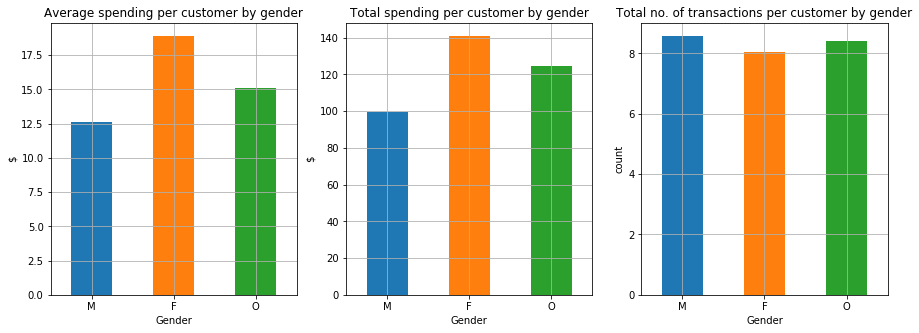

In [198]:
#customer spending by gender
plt.figure(figsize=(15,5))

plt.subplot(131)
get_customer_view().groupby(['gender'])['avg_spending'].mean().reindex(['M','F','O']).plot(kind='bar', rot=0)
plt.title('Average spending per customer by gender')
plt.ylabel('$')
plt.xlabel('Gender')
plt.grid()

plt.subplot(132)
get_customer_view().groupby(['gender'])['total_spending'].mean().reindex(['M','F','O']).plot(kind='bar', rot=0)
plt.title('Total spending per customer by gender')
plt.ylabel('$')
plt.xlabel('Gender')
plt.grid()

plt.subplot(133)
get_customer_view().groupby(['gender'])['total_transactions'].mean().reindex(['M','F','O']).plot(kind='bar', rot=0)
plt.title('Total no. of transactions per customer by gender')
plt.ylabel('count')
plt.xlabel('Gender')
plt.grid()


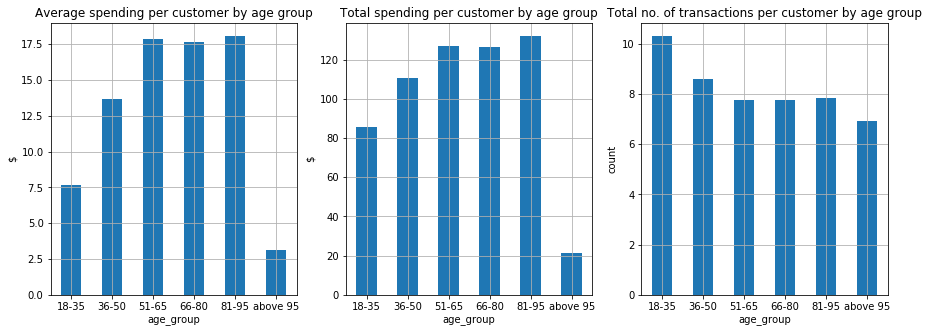

In [199]:
#customer spending by age group
plt.figure(figsize=(15,5))

plt.subplot(131)
get_customer_view().groupby(['age_group'])['avg_spending'].mean().plot(kind='bar', rot=0, color='#1f77b4')
plt.title('Average spending per customer by age group')
plt.ylabel('$')
plt.xlabel('age_group')
plt.grid()

plt.subplot(132)
get_customer_view().groupby(['age_group'])['total_spending'].mean().plot(kind='bar', rot=0, color='#1f77b4')
plt.title('Total spending per customer by age group')
plt.ylabel('$')
plt.xlabel('age_group')
plt.grid()

plt.subplot(133)
get_customer_view().groupby(['age_group'])['total_transactions'].mean().plot(kind='bar', rot=0, color='#1f77b4')
plt.title('Total no. of transactions per customer by age group')
plt.ylabel('count')
plt.xlabel('age_group')
plt.grid()

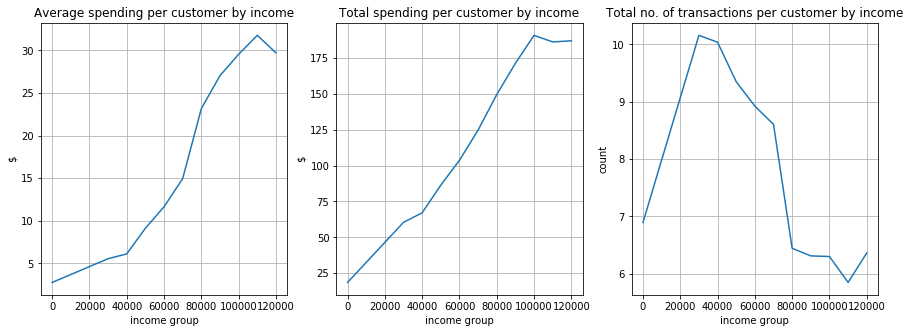

In [200]:
#customer spending by income
plt.figure(figsize=(15,5))

plt.subplot(131)
get_customer_view().groupby(['income_group'])['avg_spending'].mean().plot(kind='line', rot=0, color='#1f77b4')
plt.title('Average spending per customer by income')
plt.ylabel('$')
plt.xlabel('income group')
plt.grid()


plt.subplot(132)
get_customer_view().groupby(['income_group'])['total_spending'].mean().plot(kind='line', rot=0, color='#1f77b4')
plt.title('Total spending per customer by income')
plt.ylabel('$')
plt.xlabel('income group')
plt.grid()

plt.subplot(133)
get_customer_view().groupby(['income_group'])['total_transactions'].mean().plot(kind='line', rot=0, color='#1f77b4')
plt.title('Total no. of transactions per customer by income')
plt.ylabel('count')
plt.xlabel('income group')
plt.grid()

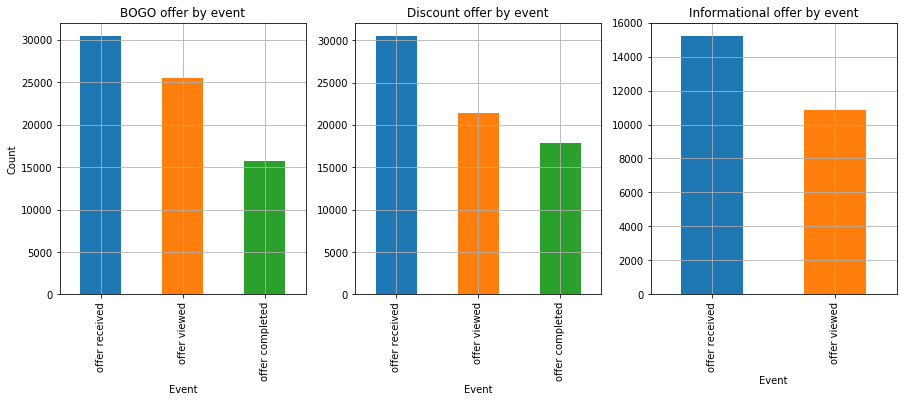

In [201]:
#create charts to show the offer and event count
plt.figure(figsize=(15,5))

plt.subplot(131)
all_trx[all_trx['offer_type'] == 'bogo'].event.value_counts().plot.bar()
plt.ylabel('Count')
plt.xlabel('Event')
plt.title('BOGO offer by event');
plt.grid()

plt.subplot(132)
all_trx[all_trx['offer_type'] == 'discount'].event.value_counts().plot.bar()
plt.xlabel('Event')
plt.title('Discount offer by event');
plt.grid()

plt.subplot(133)
all_trx[all_trx['offer_type'] == 'informational'].event.value_counts().plot.bar()
plt.xlabel('Event')
plt.title('Informational offer by event');
plt.grid()

In [202]:
all_trx.groupby(['offer_type','offer_id'])['event'].value_counts()

offer_type     offer_id                          event          
bogo           4d5c57ea9a6940dd891ad53e9dbe8da0  offer received     7593
                                                 offer viewed       7298
                                                 offer completed    3331
               9b98b8c7a33c4b65b9aebfe6a799e6d9  offer received     7677
                                                 offer completed    4354
                                                 offer viewed       4171
               ae264e3637204a6fb9bb56bc8210ddfd  offer received     7658
                                                 offer viewed       6716
                                                 offer completed    3688
               f19421c1d4aa40978ebb69ca19b0e20d  offer received     7571
                                                 offer viewed       7264
                                                 offer completed    4296
discount       0b1e1539f2cc45b7b9fa7c272da2e1d7  offer rece

In [203]:
#create a dataset by offer type, offer and event for further analysis 
offer_stat = all_trx.groupby(['offer_type','offer_id','offer_name','event'])
offer_stat = pd.DataFrame(offer_stat.size().reset_index(name = "event_count"))
offer_stat.drop(columns=['offer_type'],inplace=True)
offer_stat = pd.merge(offer_stat,portfolio)
offer_stat.head()

,offer_id,offer_name,event,event_count,channels,difficulty,duration,offer_type,reward,email,mobile,social,web
0,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo-9,offer completed,3331,"[web, email, mobile, social]",10,5,bogo,10,1,1,1,1
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo-9,offer received,7593,"[web, email, mobile, social]",10,5,bogo,10,1,1,1,1
2,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo-9,offer viewed,7298,"[web, email, mobile, social]",10,5,bogo,10,1,1,1,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo-0,offer completed,4354,"[web, email, mobile]",5,7,bogo,5,1,1,0,1
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo-0,offer received,7677,"[web, email, mobile]",5,7,bogo,5,1,1,0,1


In [204]:
def get_event_count(offers,offer_id,event):
    '''
    INPUT:
    offers - (pandas dataframe) all offers to be analyzed
    offer_id - offer id
    event - event ['offer received', 'offer viewed', 'offer completed']
      
    OUTPUT:
    cnt - count per offer in that event 
    
    '''
    cnt = offers[(offers.event == event) & (offers.offer_id== offer_id)].event_count.values[0]
    return cnt

In [205]:
#check how each offer is doing
unique_cust_cnt = profile.customer_id.nunique()
#reach_rate - offer received/ customer base
offer_stat.loc[offer_stat.event == "offer received",'reach_rate'] = offer_stat.event_count/ unique_cust_cnt

#view_rate - offer viewed/ offer received
offer_stat.loc[offer_stat.event == "offer viewed",'view_rate'] = offer_stat.event_count/get_event_count(offer_stat,offer_stat.offer_id,"offer received")                                                                                              
                                                                                                          
#completion_rate - offer completed/ offer received
offer_stat.loc[offer_stat.event == "offer completed",'completion_rate'] = offer_stat.event_count/get_event_count(offer_stat,offer_stat.offer_id,"offer received")
offer_stat.head()

,offer_id,offer_name,event,event_count,channels,difficulty,duration,offer_type,reward,email,mobile,social,web,reach_rate,view_rate,completion_rate
0,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo-9,offer completed,3331,"[web, email, mobile, social]",10,5,bogo,10,1,1,1,1,NaN,NaN,0.438694
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo-9,offer received,7593,"[web, email, mobile, social]",10,5,bogo,10,1,1,1,1,0.446647,NaN,NaN
2,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo-9,offer viewed,7298,"[web, email, mobile, social]",10,5,bogo,10,1,1,1,1,NaN,0.961148,NaN
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo-0,offer completed,4354,"[web, email, mobile]",5,7,bogo,5,1,1,0,1,NaN,NaN,0.573423
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo-0,offer received,7677,"[web, email, mobile]",5,7,bogo,5,1,1,0,1,0.451588,NaN,NaN


In [206]:
#Categorical the event: offer received > offer viewed > offer completed
all_trx['event'] = pd.Categorical(all_trx['event'], ["offer received", "offer viewed", "offer completed"])

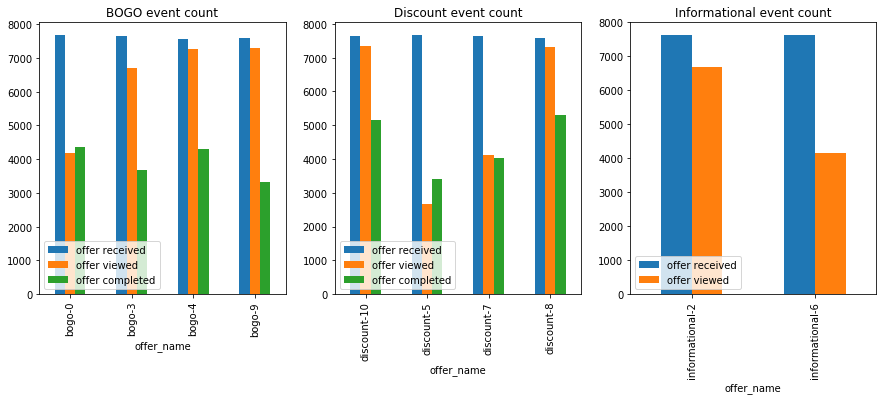

In [207]:
#create charts to show the offer and event count

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131)
all_trx[all_trx['offer_type'] == 'bogo'].groupby(['event'])['offer_name'].value_counts().unstack(0).plot(kind='bar',ax=ax1)
plt.title('BOGO event count');
plt.legend(loc='lower left');

ax2 = fig.add_subplot(132)
all_trx[all_trx['offer_type'] == 'discount'].groupby(['event'])['offer_name'].value_counts().unstack(0).plot(kind='bar',ax=ax2)
plt.title('Discount event count');
plt.legend(loc='lower left');

ax3 = fig.add_subplot(133)
all_trx[all_trx['offer_type'] == 'informational'].groupby(['event'], observed=True)['offer_name'].value_counts().unstack(0).plot(kind='bar',ax=ax3)
plt.title('Informational event count');
plt.legend(loc='lower left');

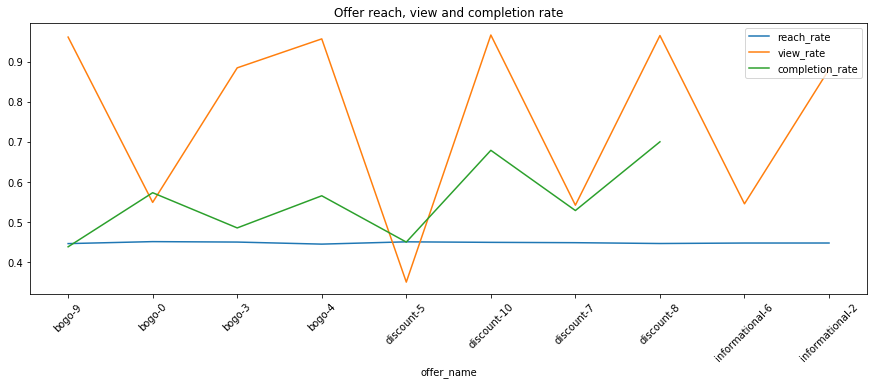

In [208]:
#create charts to reach rate, view rate, completion rate
offer_received = offer_stat[offer_stat['event'] == 'offer received']
offer_viewed = offer_stat[offer_stat['event'] == 'offer viewed']        
offer_completed = offer_stat[offer_stat['event'] == 'offer completed']


fig =plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

offer_received.plot(kind="line", x="offer_name", y="reach_rate", ax=ax)
offer_viewed.plot(kind="line", x="offer_name", y="view_rate", ax=ax)
offer_completed.plot(kind="line", x="offer_name", y="completion_rate", ax=ax)
                             
xticks = offer_received.offer_name.unique().tolist()
xindex = list(range(len(xticks)))

plt.xticks(xindex, xticks, rotation=45)
plt.legend(loc = 'upper right')
plt.title('Offer reach, view and completion rate');
plt.show()

                        

In [209]:
offer_stat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 0 to 27
Data columns (total 16 columns):
offer_id           28 non-null object
offer_name         28 non-null object
event              28 non-null object
event_count        28 non-null int64
channels           28 non-null object
difficulty         28 non-null int64
duration           28 non-null int64
offer_type         28 non-null object
reward             28 non-null int64
email              28 non-null int64
mobile             28 non-null int64
social             28 non-null int64
web                28 non-null int64
reach_rate         10 non-null float64
view_rate          10 non-null float64
completion_rate    8 non-null float64
dtypes: float64(3), int64(8), object(5)
memory usage: 5.0+ KB


In [210]:
#apply one hot encoding for offer_type column
offer_encode = {'bogo': 0, 'discount': 1, 'informational': 2}
offer_stat['offer_encoded'] = offer_stat['offer_type'].map(offer_encode)

In [211]:
offer_stat.corr().style.background_gradient(cmap='YlOrRd')

/opt/conda/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


,event_count,difficulty,duration,reward,email,mobile,social,web,reach_rate,view_rate,completion_rate,offer_encoded
event_count,1,-0.257263,-0.167247,-0.0825099,nan,0.277592,0.349347,-0.130205,1,1,1,0.0679705
difficulty,-0.257263,1,0.779984,0.391332,nan,-0.765686,-0.196027,0.197345,0.322568,-0.299444,-0.483498,-0.230392
duration,-0.167247,0.779984,1,0.0456637,nan,-0.537164,-0.212,0.2892,0.388608,-0.253578,0.258472,-0.103215
reward,-0.0825099,0.391332,0.0456637,1,nan,-0.0521387,0.297175,-0.210529,0.109239,0.22693,-0.69965,-0.829522
email,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mobile,0.277592,-0.765686,-0.537164,-0.0521387,nan,1,0.430644,-0.161515,-0.406957,0.611129,0.423339,-0.141421
social,0.349347,-0.196027,-0.212,0.297175,nan,0.430644,1,-0.375053,-0.514496,0.962105,0.298031,-0.223906
web,-0.130205,0.197345,0.2892,-0.210529,nan,-0.161515,-0.375053,1,-0.156017,-0.273873,0.277393,-0.057104
reach_rate,1,0.322568,0.388608,0.109239,nan,-0.406957,-0.514496,-0.156017,1,nan,nan,-0.0348152
view_rate,1,-0.299444,-0.253578,0.22693,nan,0.611129,0.962105,-0.273873,nan,1,nan,-0.242121


In [212]:
offer_stat.email.describe()

count    28.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: email, dtype: float64

In [213]:
offer_viewed.sort_values(by='view_rate')

,offer_id,offer_name,event,event_count,channels,difficulty,duration,offer_type,reward,email,mobile,social,web,reach_rate,view_rate,completion_rate
14,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount-5,offer viewed,2663,"[web, email]",20,10,discount,5,1,0,0,1,NaN,0.350718,NaN
20,2906b810c7d4411798c6938adc9daaa5,discount-7,offer viewed,4118,"[web, email, mobile]",10,7,discount,2,1,1,0,1,NaN,0.542342,NaN
25,3f207df678b143eea3cee63160fa8bed,informational-6,offer viewed,4144,"[web, email, mobile]",0,4,informational,0,1,1,0,1,NaN,0.545766,NaN
5,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo-0,offer viewed,4171,"[web, email, mobile]",5,7,bogo,5,1,1,0,1,NaN,0.549322,NaN
27,5a8bc65990b245e5a138643cd4eb9837,informational-2,offer viewed,6687,"[email, mobile, social]",0,3,informational,0,1,1,1,0,NaN,0.880680,NaN
8,ae264e3637204a6fb9bb56bc8210ddfd,bogo-3,offer viewed,6716,"[email, mobile, social]",10,7,bogo,10,1,1,1,0,NaN,0.884499,NaN
11,f19421c1d4aa40978ebb69ca19b0e20d,bogo-4,offer viewed,7264,"[web, email, mobile, social]",5,5,bogo,5,1,1,1,1,NaN,0.956671,NaN
2,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo-9,offer viewed,7298,"[web, email, mobile, social]",10,5,bogo,10,1,1,1,1,NaN,0.961148,NaN
23,fafdcd668e3743c1bb461111dcafc2a4,discount-8,offer viewed,7327,"[web, email, mobile, social]",10,10,discount,2,1,1,1,1,NaN,0.964968,NaN
17,2298d6c36e964ae4a3e7e9706d1fb8c2,discount-10,offer viewed,7337,"[web, email, mobile, social]",7,7,discount,3,1,1,1,1,NaN,0.966285,NaN


In [214]:
offer_completed.sort_values(by='completion_rate')

,offer_id,offer_name,event,event_count,channels,difficulty,duration,offer_type,reward,email,mobile,social,web,reach_rate,view_rate,completion_rate
0,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo-9,offer completed,3331,"[web, email, mobile, social]",10,5,bogo,10,1,1,1,1,NaN,NaN,0.438694
12,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount-5,offer completed,3420,"[web, email]",20,10,discount,5,1,0,0,1,NaN,NaN,0.450415
6,ae264e3637204a6fb9bb56bc8210ddfd,bogo-3,offer completed,3688,"[email, mobile, social]",10,7,bogo,10,1,1,1,0,NaN,NaN,0.485711
18,2906b810c7d4411798c6938adc9daaa5,discount-7,offer completed,4017,"[web, email, mobile]",10,7,discount,2,1,1,0,1,NaN,NaN,0.529040
9,f19421c1d4aa40978ebb69ca19b0e20d,bogo-4,offer completed,4296,"[web, email, mobile, social]",5,5,bogo,5,1,1,1,1,NaN,NaN,0.565784
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo-0,offer completed,4354,"[web, email, mobile]",5,7,bogo,5,1,1,0,1,NaN,NaN,0.573423
15,2298d6c36e964ae4a3e7e9706d1fb8c2,discount-10,offer completed,5156,"[web, email, mobile, social]",7,7,discount,3,1,1,1,1,NaN,NaN,0.679046
21,fafdcd668e3743c1bb461111dcafc2a4,discount-8,offer completed,5317,"[web, email, mobile, social]",10,10,discount,2,1,1,1,1,NaN,NaN,0.700250


# Recommendation Engines

In [215]:
#Rank Based Recommendations (based on completion rate)
def get_top_offers(n, offer_stat=offer_stat):
    '''
    INPUT:
    n - (int) the number of top offers to return based on completion rate
    df - (pandas dataframe) offer_stat as defined above
    
    OUTPUT:
    top_offers- (list) A list of the top 'n' offer namess 
    
    '''
    top_offer_names = offer_stat.sort_values(by=['completion_rate'],ascending=False).offer_name
    top_offers = top_offer_names[:n,].tolist()    
    return top_offers # Return the top offer names 


In [216]:
get_top_offers(3)

['discount-8', 'discount-10', 'bogo-0']

In [217]:
offer_stat.sort_values(by=['difficulty'],ascending=False)

,offer_id,offer_name,event,event_count,channels,difficulty,duration,offer_type,reward,email,mobile,social,web,reach_rate,view_rate,completion_rate,offer_encoded
14,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount-5,offer viewed,2663,"[web, email]",20,10,discount,5,1,0,0,1,NaN,0.350718,NaN,1
12,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount-5,offer completed,3420,"[web, email]",20,10,discount,5,1,0,0,1,NaN,NaN,0.450415,1
13,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount-5,offer received,7668,"[web, email]",20,10,discount,5,1,0,0,1,0.451059,NaN,NaN,1
23,fafdcd668e3743c1bb461111dcafc2a4,discount-8,offer viewed,7327,"[web, email, mobile, social]",10,10,discount,2,1,1,1,1,NaN,0.964968,NaN,1
22,fafdcd668e3743c1bb461111dcafc2a4,discount-8,offer received,7597,"[web, email, mobile, social]",10,10,discount,2,1,1,1,1,0.446882,NaN,NaN,1
21,fafdcd668e3743c1bb461111dcafc2a4,discount-8,offer completed,5317,"[web, email, mobile, social]",10,10,discount,2,1,1,1,1,NaN,NaN,0.700250,1
20,2906b810c7d4411798c6938adc9daaa5,discount-7,offer viewed,4118,"[web, email, mobile]",10,7,discount,2,1,1,0,1,NaN,0.542342,NaN,1
19,2906b810c7d4411798c6938adc9daaa5,discount-7,offer received,7632,"[web, email, mobile]",10,7,discount,2,1,1,0,1,0.448941,NaN,NaN,1
18,2906b810c7d4411798c6938adc9daaa5,discount-7,offer completed,4017,"[web, email, mobile]",10,7,discount,2,1,1,0,1,NaN,NaN,0.529040,1
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo-9,offer received,7593,"[web, email, mobile, social]",10,5,bogo,10,1,1,1,1,0.446647,NaN,NaN,0


In [218]:
#Rank Based Recommendations (based on total spending)
def get_top_offers_by_spending(customers, n=3):
    '''
    INPUT:
    customers - customer view with the transaction details
    n - (int) the number of top offers to return
    df - (pandas dataframe) customer dataframe 
    
    OUTPUT:
    top_offers- (list) A list of the top 'n' offer namess 
    
    '''
    conditions = (customers.total_offer_completed>0)
    
    top_offer_names = customers.sort_values(by=['total_spending'],ascending=False).top_offer.unique() 
    top_offers = top_offer_names[:n].tolist()
 
    return top_offers[:n]

In [219]:
get_top_offers_by_spending(get_customer_view(),3)

['bogo-4', 'discount-7', 'bogo-0']

In [220]:
#Knowledge Based Recommendations (Creating Filters)
def get_top_offers_filtered(customers, n=3, gender=None, income=None, age=None):
    '''
    INPUT:
    customers - customer view with the transaction details
    n - (int) the number of top offers to return
    df - (pandas dataframe) customer dataframe 
    gender, income, age - other parameters for the filters
    
    OUTPUT:
    top_offers- (list) A list of the top 'n' offer namess 
    
    '''
    conditions = (customers.total_offer_completed>0)

    if gender:
        conditions = conditions & (customers.gender == gender)
        
    if income:
        income_grp = income_group(income)
        if income_grp > 0:
            conditions = conditions & (customers.income_group == income_grp)
        #conditions = conditions & (customers.income == gender)
        
    if age:
        age_grp = age_group(age)
        conditions = conditions & (customers.age_group == age_grp)
    
    top_offer_names = customers[conditions].sort_values(by=['total_spending'],ascending=False).top_offer.unique() 
    top_offers = top_offer_names[:n].tolist()
 
    return top_offers[:n]


In [221]:
get_top_offers_filtered(get_customer_view(),income=30000)

['bogo-4', 'discount-5', 'bogo-0']

In [222]:
get_top_offers_filtered(get_customer_view(),income=100000)

['bogo-4', 'bogo-0', 'bogo-3']

In [223]:
get_top_offers_filtered(get_customer_view(),age=18)

['discount-7', 'bogo-4', 'discount-10']

In [224]:
get_top_offers_filtered(get_customer_view(),age=65)

['bogo-0', 'bogo-3', 'discount-5']

In [225]:
get_top_offers_filtered(get_customer_view(),gender='M')

['bogo-4', 'discount-7', 'bogo-0']

In [226]:
get_top_offers_filtered(get_customer_view(),gender='F')

['bogo-0', 'bogo-3', 'discount-5']

In [227]:
get_top_offers_filtered(get_customer_view())

['bogo-4', 'discount-7', 'bogo-0']

In [228]:
# create the customer-offer matrix with 1's and 0's
#offer_completed = all_trx[all_trx['event'] == 'offer completed']
def create_customer_offer_matrix(offer_completed=all_trx):
    '''
    INPUT:
    all_trx - pandas dataframe with offer_id, offer_name, customer_id columns
    
    OUTPUT:
    user_offer - user offer matrix 
    
    Description:
    Return a matrix with customer ids as rows and offer_name on the columns with 1 values where a customer completed 
    an offer and a 0 otherwise
    '''
    # Fill in the function here
    
    offers = ['bogo-0','bogo-3', 'bogo-4', 'discount-5', 'discount-7', 'discount-8', 'bogo-9', 'discount-10']
    
    #for offer in offers:
    #    customer_offer[offer] = offer_completed[offer_completed.offer_name==offer].groupby(['customer_id']).offer_name.count()
    #    customer_offer[offer] = customer_offer[offer].fillna(0)
    
    customer_offer = pd.DataFrame()
    customer_offer = pd.DataFrame(customer_offer, columns = offers)
    for offer in offers:
        if (offer_completed[offer_completed.offer_name==offer].shape[0]>0):
            customer_offer[offer] = offer_completed[(offer_completed.offer_name==offer)].groupby(['customer_id']).offer_name.count()
        #else:
            #customer_offer[offer] = 0.0
    customer_offer.fillna(0, inplace=True)

    #customer_offer = all_trx[all_trx['event'] == 'offer completed'].pivot_table(values='offer_id', index='customer_id', columns='offer_name', aggfunc=lambda x: 1, fill_value=0)
    #customer_offer = get_customer_view(offer_completed)[['bogo-0','bogo-3', 'bogo-4', 'discount-5', 'discount-7', 'discount-8', 'bogo-9', 'discount-10']]
    # Create customer-by-offer matrix
    #customer_offer = offer_completed[['customer_id', 'offer_name']]
    #customer_by_offer = customer_offer.groupby(['customer_id', 'offer_name']).offer_name.value_counts().unstack().apply(lambda x:x.fillna(0))


    return customer_offer # return the user_offer matrix 

customer_offer = create_customer_offer_matrix(all_trx)
customer_offer.head()

,bogo-0,bogo-3,bogo-4,discount-5,discount-7,discount-8,bogo-9,discount-10
customer_id,,,,,,,,
0011e0d4e6b944f998e987f904e8c1e5,3,0.0,0.0,3.0,0.0,0.0,0.0,3.0
0020ccbbb6d84e358d3414a3ff76cffd,3,0.0,3.0,0.0,0.0,0.0,0.0,3.0
005500a7188546ff8a767329a2f7c76a,2,6.0,0.0,0.0,1.0,0.0,0.0,0.0
0056df74b63b4298809f0b375a304cf4,3,0.0,0.0,2.0,0.0,0.0,0.0,3.0
0063def0f9c14bc4805322a488839b32,2,2.0,0.0,2.0,0.0,0.0,0.0,2.0


In [229]:
# create the customer-offer matrix with 1's and 0's
offer_completed = all_trx[all_trx['event'] == 'offer completed']
def create_customer_offer_matrix(offer_completed=offer_completed):
    '''
    INPUT:
    all_trx - pandas dataframe with offer_id, offer_name, customer_id columns
    
    OUTPUT:
    user_offer - user offer matrix 
    
    Description:
    Return a matrix with customer ids as rows and offer_name on the columns with 1 values where a customer completed 
    an offer and a 0 otherwise
    '''
    # Fill in the function here
    
    offers = ['bogo-0','bogo-3', 'bogo-4', 'discount-5', 'discount-7', 'discount-8', 'bogo-9', 'discount-10']
    
    #for offer in offers:
    #    customer_offer[offer] = offer_completed[offer_completed.offer_name==offer].groupby(['customer_id']).offer_name.count()
    #    customer_offer[offer] = customer_offer[offer].fillna(0)
    
    #offer_completed.customer
    offer_completed =offer_completed[['customer_id']].drop_duplicates()
    temp = pd.merge(get_customer_view(),offer_completed , how='inner', right_index= True, on='customer_id')   
    customer_offer = temp[offers]

    #offer_completed.groupby(['customer_id','offer_name']).offer_id.count().unstack()


    return customer_offer # return the user_offer matrix 

customer_offer = create_customer_offer_matrix(all_trx)
customer_offer.head()

,bogo-0,bogo-3,bogo-4,discount-5,discount-7,discount-8,bogo-9,discount-10
0009655768c64bdeb2e877511632db8f,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0011e0d4e6b944f998e987f904e8c1e5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
0020c2b971eb4e9188eac86d93036a77,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0
0020ccbbb6d84e358d3414a3ff76cffd,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [230]:
# Perform SVD on the customer_offer Matrix Here
u, s, vt = np.linalg.svd(customer_offer)# use the built in to get the three matrices

In [231]:
u.shape, s.shape, vt.shape

((17000, 17000), (8,), (8, 8))

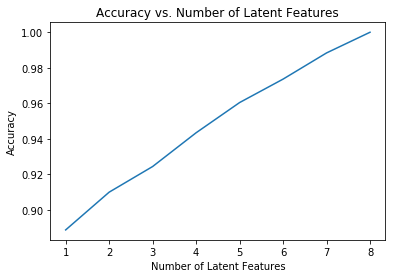

In [232]:
num_latent_feats = np.arange(1,8+1,1)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    customer_offer_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(customer_offer, customer_offer_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/all_trx.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [233]:
trx_train = offer_completed.head(5000)
trx_test = offer_completed.tail(100)

def create_test_and_train_customer_offer(trx_train, trx_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    customer_offer_train - a customer_offer matrix of the training dataframe 
                      (unique customer for each row and unique offers for each column)
    customer_offer_test - a customer_offer matrix of the testing dataframe 
                    (unique customer for each row and unique offers for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    customer_offer_train = create_customer_offer_matrix(trx_train)
    customer_offer_test = create_customer_offer_matrix(trx_test)
    test_idx = set(customer_offer_test.index)
    test_offers = set(customer_offer_test.columns)
    
    return customer_offer_train, customer_offer_test, test_idx, test_offers

customer_offer_train, customer_offer_test, test_idx, test_offers = create_test_and_train_customer_offer(trx_train, trx_test)

In [234]:
# common users in both test and train set
customer_offer_train.index.isin(test_idx).sum()

15

In [235]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(customer_offer_train) # fit svd similar to above then use the cells below

In [236]:
u_train.shape, s_train.shape, vt_train.shape


((4177, 4177), (8,), (8, 8))

In [237]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
train_common_ids  = customer_offer_train.index.isin(test_idx)
train_common_cols  = customer_offer_train.columns.isin(test_offers)

u_test = u_train[train_common_ids, :]
vt_test = vt_train[:, train_common_cols]

In [238]:
u_test.shape, vt_test.shape

((15, 4177), (8, 8))

In [239]:
train_idx = customer_offer_train.index

common_ids = list(set(train_idx)&set(test_idx)) 
common_cols = customer_offer_train.columns.intersection(test_offers)

customer_offer_test = customer_offer_test.loc[common_ids]

In [240]:
customer_offer_test.shape

(15, 8)

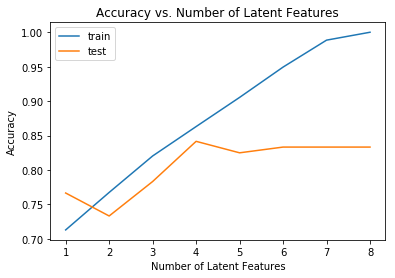

In [241]:
num_latent_feats = np.arange(1,8+1,1)
train_sum_errs = []
test_sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    customer_offer_train_est = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    customer_offer_test_est = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(customer_offer_train, customer_offer_train_est)
    diffs_test = np.subtract(customer_offer_test, customer_offer_test_est)
    
    # total errors and keep track of them
    train_err = np.sum(np.sum(np.abs(diffs_train)))
    train_sum_errs.append(train_err)
    
    test_err = np.sum(np.sum(np.abs(diffs_test)))
    test_sum_errs.append(test_err)    
    
plt.plot(num_latent_feats, 1 - np.array(train_sum_errs)/(customer_offer_train.shape[0]*customer_offer_train.shape[1]), label="train");
plt.plot(num_latent_feats, 1 - np.array(test_sum_errs)/(customer_offer_test.shape[0]*customer_offer_test.shape[1]), label="test");
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend();